# `kamene`: Sniffing Network Packets

`kamene` is a python package for dissecting and implementing network protocols.

Full documentation can be found at: http://www.secdev.org/projects/kamene/doc/

## 1. Importing `kamene`

The first 2 lines of the next cell suppress warnings from the `kamene` package.

In [1]:
import logging
logging.getLogger("kamene.runtime").setLevel(logging.ERROR)
from kamene.all import *
from pynq_networking import *

## 2. Sniffing packets

`kamene` can sniff packets off the wire and process and display them.

The filter is a string in the Berkeley packet filter style: http://biot.com/capstats/bpf.html.

The `nsummary()` method prints a summary of each packet,
along with its index in the collection.

The next cell will sniff packets for 2 seconds and spit out the packet trace.

In [2]:
import signal, time

def time_out(signum, frame):
    raise KeyboardInterrupt

signal.signal(signal.SIGALRM, time_out)
signal.alarm(2)

try:
    pkt_trace = sniff(iface="br0", filter="udp or arp")
except KeyboardInterrupt:
    pass
pkt_trace.nsummary()

0000 Ether / ARP who has 172.19.74.59 says 172.19.75.254 / Padding
0001 Ether / IP / UDP 172.19.73.185:54915 > 172.19.75.255:54915 / Raw
0002 Ether / ARP who has 172.19.3.254 says 172.19.3.129 / Padding
0003 Ether / IPv6 / UDP fe80::e46b:e97a:587e:2974:dhcpv6_client > ff02::1:2:dhcpv6_server / DHCP6_Solicit / DHCP6OptElapsedTime / DHCP6OptClientId / DHCP6OptIA_NA / DHCP6OptClientFQDN / DHCP6OptVendorClass / DHCP6OptOptReq
0004 Ether / IP / UDP 172.19.72.175:54915 > 172.19.75.255:54915 / Raw
0005 Ether / ARP who has 172.19.75.254 says 172.19.73.202 / Padding
0006 Ether / IP / UDP 172.19.72.82:54915 > 172.19.75.255:54915 / Raw
0007 Ether / IPv6 / UDP fe80::65ae:6817:126:d39b:54300 > ff02::1:3:hostmon / LLMNRQuery
0008 Ether / IP / UDP 172.19.73.202:61365 > 224.0.0.252:hostmon / LLMNRQuery
0009 Ether / IP / UDP 172.19.74.149:1534 > 172.19.75.255:1534 / Raw / Padding
0010 Ether / IPv6 / UDP fe80::65ae:6817:126:d39b:54300 > ff02::1:3:hostmon / LLMNRQuery
0011 Ether / IP / UDP 172.19.73.202:

If you execute the previous code on a busy network, you'll probably see lots of packets which are not MQTTSN packets.
The following code separates the MQTTSN packets from the other 'uninteresting' packets.
In this code x[MQTTSN] returns the first MQTTSN header and the `.payload` field returns the rest of the packet, 
which depends on the particular type of MQTTSN packet.
In this case, if you managed to sniff some MQTTSN packets, you might see something like:

```
<MQTTSN_CONNECT  dup=0 qos=0 retain=0 will=0 clean=1 topicIDtype=0 protocol=1 duration=30 client='client-temp' |>,
<MQTTSN_CONNACK  returnCode=0 |>,
 ```
 
These packets represent a connect request followed by an acknowledgment.

We can also do various kinds of analysis on the captured packets, as shown below.

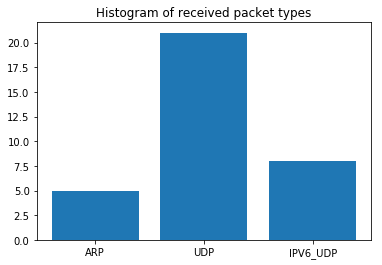

In [3]:
import matplotlib.pyplot as plt
from collections import Counter
types = ["ARP" if ARP in x else 
         "MQTTSN" if MQTTSN in x else
         "IPV6_UDP" if ((UDP in x) and (IPv6 in x)) else
         "UDP" if (UDP in x) else
         "IPV6_TCP" if ((TCP in x) and (IPv6 in x)) else
         "TCP" if (TCP in x) else
         "Unknown" for x in pkt_trace]
counts = Counter(types)
frequencies = counts.values()
names = [x for x in counts.keys()]
centers = range(len(counts))
plt.bar(centers, frequencies, align='center', tick_label=names)
plt.title("Histogram of received packet types")
plt.show()

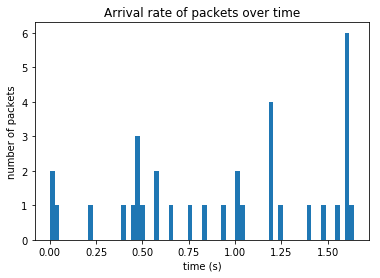

In [4]:
import matplotlib.pyplot as plt
if len(pkt_trace) == 0:
    print("No Data!")
else:
    first = pkt_trace[0].time
    times = [pkt.time - pkt_trace[0].time for pkt in pkt_trace]
    plt.hist(times, bins=64)
    plt.title("Arrival rate of packets over time")
    plt.xlabel('time (s)')
    plt.ylabel('number of packets')
    plt.show()

## 3. Sniffing in the background
Now let us write a script `sniff.py` to be running in the background. 
This script will collect 100 UDP packets silently, and dump the packet
trace into a log file `packet.log`.

In [5]:
num_packets = 100

with open('sniff.py', 'w') as file:
    file.write(
        'import logging\n')
    file.write(
        'logging.getLogger("kamene.runtime").setLevel(logging.ERROR)\n')
    file.write(
        'from kamene.all import *\n')
    file.write(
        'sniffer = sniff(iface="br0", filter=f"udp", \n')
    file.write(
        '                count={})\n'.format(num_packets))
    file.write(
        'print(sniffer.nsummary())\n')

os.system("chmod 777 sniff.py")
os.system("python3.6 sniff.py >packet.log&")

0

It may take some time for the background sniffing process to complete. 

Use the following command line to check whether the process 
has completed:
```
ps -aux | grep 'sniff.py'
```

After it is done, users can check the contents in `packet.log`.

Finally, remove all the generated files.

In [6]:
os.system("rm -rf sniff.py packet.log")

0